In [1]:
using LCIO
using StatsPlots
using Printf
using Corpuscles

┌ Info: Precompiling LCIO [94167541-0a4e-5fbf-aeea-474b87c587e3]
└ @ Base loading.jl:1278
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278
┌ Info: Precompiling Corpuscles [e78a0372-c628-4773-9c8d-eb17d149bf93]
└ @ Base loading.jl:1278


First, let's take a look at what's in the files. We create a dictionary with nice labels for the four files in the example. Adjust the path of the files to point to the location on your computer.

In [2]:
const fnames = Dict(
    "μμH_eLpR" => "/collab/project/snowmass21/data/ilc/tutorial/rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I106479.Pe2e2h.eL.pR-00001-ILDminiDST.slcio",
    "μμH_eRpL" => "/collab/project/snowmass21/data/ilc/tutorial/rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I106480.Pe2e2h.eR.pL-00001-ILDminiDST.slcio",
    "zz_sl_eLpR" => "/collab/project/snowmass21/data/ilc/tutorial/rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I106575.P4f_zz_sl.eL.pR-00001-ILDminiDST.slcio", 
    "zz_sl_eRpL" => "/collab/project/snowmass21/data/ilc/tutorial/rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I106576.P4f_zz_sl.eR.pL-00001-ILDminiDST.slcio"
)

Dict{String,String} with 4 entries:
  "zz_sl_eRpL" => "/collab/project/snowmass21/data/ilc/tutorial/rv01-16-p10_250…
  "μμH_eLpR"   => "/collab/project/snowmass21/data/ilc/tutorial/rv01-16-p10_250…
  "μμH_eRpL"   => "/collab/project/snowmass21/data/ilc/tutorial/rv01-16-p10_250…
  "zz_sl_eLpR" => "/collab/project/snowmass21/data/ilc/tutorial/rv01-16-p10_250…

In [3]:
LCIO.open(fnames["μμH_eLpR"]) do reader
    for event in reader
        println(repeat("/", 35))
        println("EVENT: ", getEventNumber(event))
        println("RUN: ", getRunNumber(event))
        println("DETECTOR: ", getDetectorName(event))
        println("COLLECTIONS: (see below)")
        println(repeat("/", 35))
        println()
        println(repeat("-", 100))
        @printf("%-40s%-40s%-10s\n", "Collection Name", "Element Type", "Elements")
        println(repeat("=", 100))
        for name in getCollectionNames(event)
            c = getCollection(event, name)
            @printf("%-40s%-40s%-10d\n", name, getTypeName(c), length(c))
        end
        println(repeat("-", 100))
        println()
        println()
        break
    end
end

///////////////////////////////////
EVENT: 0
RUN: 51
DETECTOR: ILD_o1_v05
COLLECTIONS: (see below)
///////////////////////////////////

----------------------------------------------------------------------------------------------------
Collection Name                         Element Type                            Elements  
BCALParticles                           LCIO.ReconstructedParticle              0         
IsolatedElectrons                       LCIO.ReconstructedParticle              0         
IsolatedMuons                           LCIO.ReconstructedParticle              2         
IsolatedPhotons                         LCIO.ReconstructedParticle              0         
IsolatedTaus                            LCIO.ReconstructedParticle              0         
MCParticlesSkimmed                      LCIO.MCParticle                         128       
PandoraPFANewReclusterMonitoring        LCIO.LCGenericObject                    0         
PandoraPFOs                        

In [4]:
LCIO.open(fnames["μμH_eLpR"]) do reader
    for event in reader
        @printf("%-6s %7s %-10s%-10s%-3s\n", "Index", "PDG", "name", "parents", "generatorStatus")
        for (idx, mcp) in enumerate(getCollection(event, "MCParticlesSkimmed"))
            pdg = getPDG(mcp)
            if 90 < pdg < 99 
                name = "internal"
            elseif abs(pdg) > 20000
                name = "unknown"
            else
                name = Particle(pdg).name
            end
            parents = getParents(mcp)
            
            @printf("%6s %7s %-10s%-10s%-3s\n",
                idx,
                pdg,
                name,
                length(parents) > 0 ? getPDG(parents[1]) : 0,
                getGeneratorStatus(mcp)
            )
        end
        println(repeat("-", 100))
        break
    end
end

Index      PDG name      parents   generatorStatus
     1      22 gamma     0         2  
     2      22 gamma     0         2  
     3      13 mu        0         2  
     4     -13 mu        0         2  
     5      25 H         0         2  
     6      22 gamma     22        1  
     7      22 gamma     22        1  
     8      13 mu        13        2  
     9     -13 mu        -13       2  
    10      25 H         25        2  
    11      94 internal  -13       2  
    12      13 mu        94        1  
    13     -13 mu        94        2  
    14     -13 mu        -13       1  
    15      22 gamma     -13       1  
    16       5 b         25        2  
    17      -5 b         25        2  
    18      94 internal  5         2  
    19       5 b         94        2  
    20      -5 b         94        2  
    21       5 b         5         2  
    22      21 g         5         2  
    23      -5 b         -5        2  
    24      21 g         -5        2  
    25      2

In [5]:
function inv_mass(part1, part2)
    e = getEnergy(part1) + getEnergy(part2)
    p = getMomentum(part1) + getMomentum(part2)
    sqrt(e^2 - sum(p.^2))
end

inv_mass (generic function with 1 method)

In [6]:
const isDelphes = false

function recoil_mass(μ₁, μ₂)
    E_initial = 250.0
    px_initial = 0.0
    # in full sim & SGV, correct for crossing angle
    if !isDelphes
         px_initial = E_initial * 0.007
         E_initial = 2.0sqrt((0.5*E_initial)^2 + px_initial^2)
    end
    recoilE = E_initial - getEnergy(μ₁) - getEnergy(μ₂)
    recoilP = [px_initial, 0, 0] - getMomentum(μ₁) - getMomentum(μ₂)
    sqrt(recoilE^2 - sum(recoilP.^2))
end

fail2muon = 0
recoilMassList = Float64[]
nEvents = 0
LCIO.open(fnames["μμH_eLpR"]) do reader
    for event in reader
        global nEvents
        global fail2muon
        
        nEvents += 1
        muons = getCollection(event, "IsolatedMuons")
        pfos = getCollection(event, "PandoraPFOs")
        # for simplicity only consider events with two muons
        if length(muons) != 2
            fail2muon += 1
            continue
        end
        # the two muons and their four-vectors
        μ₁ = muons[1]
        μ₂ = muons[2]
        push!(recoilMassList, recoil_mass(μ₁, μ₂))
    end
end

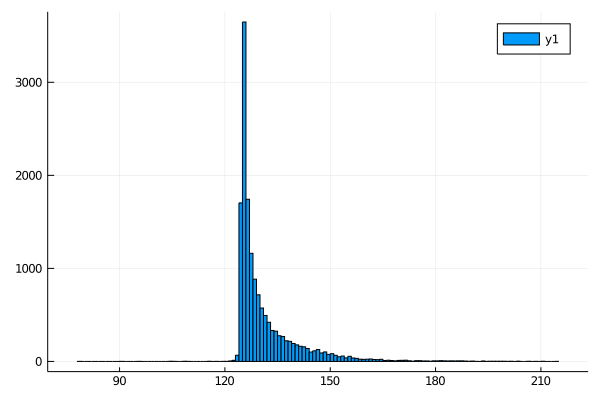

In [7]:
histogram(recoilMassList)

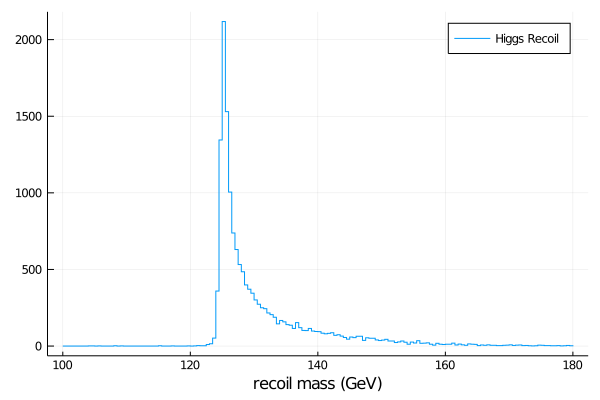

In [8]:
plot(
    recoilMassList, 
    seriestype=:stephist,
    bins=100:0.5:180,
    label="Higgs Recoil",
    xlabel="recoil mass (GeV)"
)

In [9]:
println(nEvents, " events read from file: ", fnames["μμH_eLpR"])
println("out of which ", fail2muon, " events don't have two muons ")  

17143 events read from file: /collab/project/snowmass21/data/ilc/tutorial/rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I106479.Pe2e2h.eL.pR-00001-ILDminiDST.slcio
out of which 1831 events don't have two muons 
